## Exercício 2 de Análise de Componentes Independentes


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
from scipy.cluster.vq import whiten
import pandas as pd
from pandas.plotting import scatter_matrix
from scipy.stats import entropy, chi2_contingency, shapiro
import librosa
from librosa.display import waveplot, specshow
import IPython.display as ipd

%matplotlib inline


In [2]:
def g(y):
    return np.multiply(np.power(y,2),np.sign(y))
    #return np.tanh(10*y)

def f(y):
    return np.power(y,3)

def NPCA_RLS(mixtures, learning_rate):
    P = np.identity(mixtures.shape[0])
    W = np.identity(mixtures.shape[0])
    y = np.zeros(mixtures.shape)
    beta = 0.9
    whitenedMixtures = whiten(mixtures)
    
    for i in np.arange(whitenedMixtures.shape[1]):
        y[:,i] = np.dot(W, whitenedMixtures[:,i])
        z = np.reshape(g(y[:,i]), (mixtures.shape[0], 1))
        h = np.dot(P,z)
        m = h/(beta + np.dot(np.transpose(z),h))

        Triangle = P - np.dot(m, np.transpose(h))
        lowerIndices = np.tril_indices(whitenedMixtures.shape[0])
        Triangle[lowerIndices] = Triangle.T[lowerIndices]

        P = (1/beta) * Triangle
        e =  np.reshape(whitenedMixtures[:,i], (whitenedMixtures.shape[0], 1)) - np.dot(np.transpose(W),z)

        W = W + np.dot(m,np.transpose(e))

    return y, W

def cichocki_Feedforward(mixtures, learning_rate):
    # FeedFoward
    I = np.identity(mixtures.shape[0])
    W = I
    y = np.zeros(mixtures.shape)
    dW = np.ones(W.shape) - I
    
    whitenedMixtures = whiten(mixtures)

    for i in np.arange(mixtures.shape[1]):
        input_ = np.reshape(whitenedMixtures[:,i], (mixtures.shape[0], 1))

        y[:,i] = np.reshape(np.dot(W, input_), (mixtures.shape[0],))
        gY = np.reshape(g(y[:,i]), (mixtures.shape[0],1))
        fY = np.reshape(f(y[:,i]), (mixtures.shape[0],1))
        
        dW = np.dot(I-np.dot(fY,np.transpose(gY)),W)
        W = W + learning_rate*dW
        if (np.isnan(W).any() == True):
            print('Lost convergence at iterator %d'%i)
            break
    return y, W

def cichocki_Feedback(mixtures, learning_rate):
    # Feedback
    I = np.identity(mixtures.shape[0])
    W = np.zeros((mixtures.shape[0], mixtures.shape[0]))
    y = np.zeros(mixtures.shape)
    dW = np.ones(W.shape) - I
   
    whitenedMixtures = whiten(mixtures)


    for i in np.arange(mixtures.shape[1]):
        inversa = inv(I+W)
        input_ = np.reshape(whitenedMixtures[:,i], (mixtures.shape[0], 1))

        y[:,i] = np.reshape(np.dot(inversa, input_), (mixtures.shape[0],))
        gY = np.reshape(g(y[:,i]), (mixtures.shape[0],1))
        fY = np.reshape(f(y[:,i]), (mixtures.shape[0],1))
        
        dW = np.dot((I+W),I-np.dot(fY,np.transpose(gY)))
        W = W - learning_rate*dW
        
        if (np.isnan(W).any() == True):
            print('Lost convergence at iterator %d'%i)
            break
    return y, W

def kde_entropy(x, bandwidth = 'silverman', **kwargs):
    from statsmodels.nonparametric.kde import KDEUnivariate
    """Univariate Kernel Density Estimation with Statsmodels"""
    kde = KDEUnivariate(np.reshape(x, (-1,1)))
    kde.fit(bw = bandwidth, kernel = 'gau', fft = False, **kwargs)
    
    return kde.entropy

def calculateNegentropy(x, kindOfNegentropy = 'empirical'):
    
    if kindOfNegentropy == 'KDE':
        return np.log(np.std(x)*np.sqrt(2*np.pi*np.exp(1))) - kde_entropy(x)
    elif kindOfNegentropy == 'empirical':
        gaussian_hist = np.histogram(np.random.normal(loc=np.mean(x), scale=np.std(x), size = 1000), bins = 100)[0]
        x_hist = np.histogram(x, bins = 100)[0]
        return entropy(gaussian_hist) - entropy(x_hist)
    else:
        print('Not implemented')
        return None
    
def resultsTable(y):
    import tabulate
    from IPython.display import HTML, display
    
    data = np.array([["Data", "Negentropy Test", "Shapiro-Wilk test W", "Shapiro-Wilk test P_value"]])
    for i, y_i in enumerate(y):
        shapiro_yi = shapiro(y_i)
        new_row = np.array([["%d"%i, "%.04f"%calculateNegentropy(y_i), "%.04f"%shapiro_yi[0], "%.04E"%shapiro_yi[1]]])
        data = np.concatenate((data, new_row))
    display(HTML(tabulate.tabulate(data, tablefmt = 'html', headers = 'firstrow')))
    return None

In [3]:
learning_rate = 1e-6

In [4]:
folderPath = 'E:\\OneDrive\\Documentos\\UFRJ\\Mestrado\\PEE\\ICA\\Audio\\Linear'
filePath = folderPath + '\\X1.wav'

[X1, fs] = librosa.core.load(folderPath+'\\X1.wav', sr = 44100)
[X2, fs] = librosa.core.load(folderPath+'\\X2.wav', sr = 44100)
[X3, fs] = librosa.core.load(folderPath+'\\X3.wav', sr = 44100)
[X4, fs] = librosa.core.load(folderPath+'\\X4.wav', sr = 44100)

mixture1 = np.reshape(X1, (1,-1))
mixture2 = np.reshape(X2, (1,-1))
mixture3 = np.reshape(X3, (1,-1))
mixture4 = np.reshape(X4, (1,-1))

mixtures = np.concatenate([mixture1, mixture2, mixture3, mixture4], axis = 0)
distDataFrame = pd.DataFrame(mixtures)
print(distDataFrame.T.head())

          0         1         2         3
0  0.521576  0.366394  0.210815 -0.155731
1  0.999969  0.999969  0.597931 -0.411987
2 -1.000000 -1.000000 -0.633148  0.409851
3  0.822815  0.629852  0.298279 -0.210785
4  0.311798  0.288910  0.131256 -0.097687


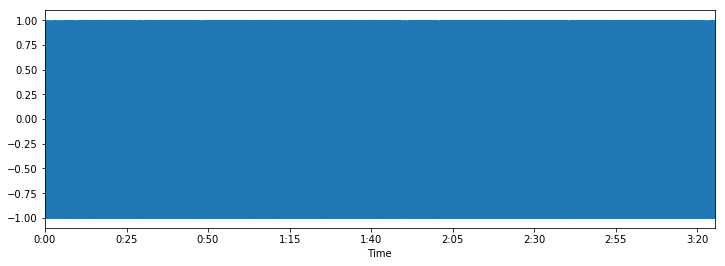

In [5]:
plt.figure(figsize=(12, 4))
waveplot(X1.T, sr=fs)
ipd.Audio(X1[:fs*3], rate=fs) 

In [6]:
[yNPCA, W] = NPCA_RLS(mixtures, 1e-6)

In [7]:
resultsTable(yNPCA[:,fs*20:fs*20+5000])

In [8]:
ipd.display(ipd.Audio(yNPCA[0][fs*10:fs*20], rate=fs))
ipd.display(ipd.Audio(yNPCA[1][fs*10:fs*20], rate=fs))

In [9]:
ipd.display(ipd.Audio(yNPCA[2][fs*10:fs*20], rate=fs))
ipd.display(ipd.Audio(yNPCA[3][fs*10:fs*20], rate=fs))

In [10]:
[yBACK, W] = cichocki_Feedback(mixtures, learning_rate)

In [11]:
resultsTable(yBACK[:,fs*20:fs*20+5000])

In [12]:
ipd.display(ipd.Audio(yBACK[0][fs*10:fs*20], rate=fs))
ipd.display(ipd.Audio(yBACK[1][fs*10:fs*20], rate=fs))

In [ ]:
ipd.display(ipd.Audio(yBACK[2][fs*10:fs*20], rate=fs))
ipd.display(ipd.Audio(yBACK[3][fs*10:fs*20], rate=fs))

In [ ]:
[yForward, W] = cichocki_Feedforward(mixtures, learning_rate)

In [ ]:
resultsTable(yForward[:,fs*20:fs*20+5000])

In [ ]:
ipd.display(ipd.Audio(yForward[0][fs*10:fs*20], rate=fs))
ipd.display(ipd.Audio(yForward[1][fs*10:fs*20], rate=fs))

In [ ]:
ipd.display(ipd.Audio(yForward[2][fs*10:fs*20], rate=fs))
ipd.display(ipd.Audio(yForward[3][fs*10:fs*20], rate=fs))